In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
from __future__ import absolute_import, print_function
import pyopencl as cl
import numpy as np
import numpy.linalg as la
from time import time
import matplotlib.pyplot as plt
%pylab inline 

VERBOSE = True
MY_PLATFORM = "AMD" # AMD, Intel, Experimental
MY_DEVICE = "GPU" # CPU, GPU, DEFAULT, ACCELERATOR 
MY_DEVICE_NUM = 0 # if multiple device types, i.e. multiple GPUs

# Print version information
print('PyOpenCL version: ' + cl.VERSION_TEXT)
print('OpenCL header version: ' + '.'.join(map(str, cl.get_cl_header_version())) + '\n')
print("Numpy version: {0}".format(np.__version__))
print("MatPlotLib version: {0}".format(matplotlib.__version__))

%install_ext https://raw.github.com/cpcloud/ipython-autotime/master/autotime.py
%load_ext autotime

Populating the interactive namespace from numpy and matplotlib
PyOpenCL version: 2015.1
OpenCL header version: 1.2

Numpy version: 1.11.1
MatPlotLib version: 1.4.3
Installed autotime.py. To use it, type:
  %load_ext autotime


C:\Anaconda2\lib\site-packages\IPython\core\magics\extension.py:47: UserWarning: %install_ext` is deprecated, please distribute your extension(s)as a python packages.
  "as a python packages.", UserWarning)


In [2]:
# choose a platform:
def choose_platform(plat_choice):
    my_platform = None
    plat = cl.get_platforms()
    try:
        for i in range(len(plat)):
            if (plat_choice.upper() in str(plat[i].name).upper()):
                my_plat = plat[i]    
        if (VERBOSE):
            if (my_plat == None):
                print (plat_choice, "platform not found!")
            else:
                print ("Platform Selected:", my_plat.name)
    except:
         print ("Exception: Failed to get platform:",plat_choice)
    return my_plat

# choose a device
def choose_device(platform_choice,device_choice,device_num):
    my_device = None
    if (device_choice.upper() == "CPU"):
        my_device = platform_choice.get_devices(cl.device_type.CPU)      
    elif (device_choice.upper() == "GPU"):
        my_device = platform_choice.get_devices(cl.device_type.GPU)
    elif (device_choice.upper() == "ACCELERATOR"):
        my_device = platform_choice.get_devices(cl.device_type.ACCELERATOR)
    elif (device_choice.upper() == "DEFAULT"):
        my_device = platform_choice.get_devices(cl.device_type.DEFAULT)
        
    if (VERBOSE >=1): print ("Device Selected: %s (%s)" % (my_device[device_num].name,device_choice.upper()))
    
    return my_device[device_num],

# setup pyopencl with platform, device, context, and queue
def setup_pyopencl(platform_choice,device_choice,device_num):
    try:
        platform = choose_platform(platform_choice)
        device = choose_device(platform, device_choice,device_num)
        context = cl.Context(device)
        queue = cl.CommandQueue(context,properties=cl.command_queue_properties.PROFILING_ENABLE)    
        return platform, device, context, queue
    except:
        print ("Unable to set up pyopencl. Please try a different platform/device.")
        print ("Make sure you have the correct platform selected.")
        return None, None, None, None

time: 32 ms


In [3]:
# non-opencl vector add function:
def python_vector_add(a,b):
    vector_c = np.zeros(len(a)).astype(np.float32)
    vector_c = a + b
    return vector_c

# pyopencl vector add kernel function:
def pyopencl_kernel_vector_add(my_plat,my_dev,my_dev_num):
    # OpenCL routines and objects
    plat, dev, ctx, queue = setup_pyopencl(my_plat,my_dev,my_dev_num)
    
    if (VERBOSE >=2):
        print ("Platform:",plat)
        print ("Device:",dev)
        print ("Context:",ctx)
        print ("Queue:",queue)
  
    # OpenCL kernel code    
    kernel_code = """
            __kernel void krnl_vecadd(__global const float * vector_a,
                                      __global const float * vector_b, 
                                      __global float * vector_c) 
            {
              int i = get_global_id(0); // Get the work-item’s unique ID
              vector_c[i] = vector_a[i] + vector_b[i];
            }
    """
    prg = cl.Program(ctx,kernel_code).build()
    return plat, dev, ctx, queue, prg


# pyopencl vector add function:
def pyopencl_vector_add(vector_a, vector_b, plat, dev, ctx, queue, prg):

    t0 = time()#t0 = datetime.datetime.now()

    # transfer from host to device
    mf = cl.mem_flags
    a_buf = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=vector_a)
    b_buf = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=vector_b)
    dest_buf = cl.Buffer(ctx, mf.WRITE_ONLY, vector_a.nbytes )
    t1 = time()
    
    prg.krnl_vecadd(queue, vector_a.shape, None, a_buf, b_buf, dest_buf)
    
    final_vector = np.empty_like(vector_a)
    t2 = time()
    
    # transfer from device back to host
    cl.enqueue_copy(queue, final_vector , dest_buf).wait()
    t3 = time()
    
    htd_time = t1 - t0 # host to device time
    ocl_time = t2 - t1 # opencl time
    dth_time = t3 - t2 # device to host time

    if (VERBOSE >=2):
        print ('OpenCL transfer to device: ' + str(htd_time))
        print ('OpenCL Vector Addition: ' + str(t2 - t1))
        print ('OpenCL transfer back to host: ' + str(t3-t2))
    
    return final_vector,htd_time,ocl_time,dth_time


time: 47 ms


In [4]:
def run_bench(plat, dev, ctx, queue, prg, v_size=10):

    t0 = time()
    a = np.random.rand(v_size).astype(np.float32)
    b = np.random.rand(v_size).astype(np.float32)
    t1 = time()

    x = (python_vector_add(a,b))
    t2 = time()
    y, htd_time,ocl_time,dth_time = (pyopencl_vector_add(a,b,plat, dev, ctx, queue, prg))
    t3 = time()
    
    vec_gen_time = t1-t0
    reg_va_time = t2-t1
    ocl_va_time = t3-t2    
    
    return x,y,vec_gen_time,reg_va_time,ocl_va_time,htd_time,ocl_time,dth_time

time: 18 ms


In [5]:
plats = ["AMD","INTEL","EXPERIMENTAL"]
devs = ["GPU","CPU"]

MY_PLATFORM = "AMD"
MY_DEVICE = "CPU"
plat, dev, ctx, queue, prg = pyopencl_kernel_vector_add(MY_PLATFORM,MY_DEVICE,MY_DEVICE_NUM)

# note only AMD has the GPU since I have a Radeon
# largest size I tested with= 120000000*32 bits = 480 megabytes
#test_sizes = [1000,10000,100000,1000000,10000000,100000000,120000000]
test_sizes = range(10000000,12000001,20000)

time_dict = {}
VERBOSE = 1
for test in test_sizes:
    print ("Running test with vector size:", test)
    time_list = []
    #x,y,vec_time,va_time,oclva_time,htd_time,ocl_time,dth_time = run_bench("AMD","CPU",test,vlow=0.0,vhigh=1.0)
    time_dict[test] = (run_bench(plat, dev, ctx, queue, prg, test))
    VERBOSE = 0

#print ("Test vector sizes:",test_sizes)
#print("Matrix generation time:", time_dict[test_sizes[1]][0][3], "s")
# for key in time_dict:
# time_dict[key][0]=x, 1=y, 2=mg_time, 3=mm_time, 4=oclmm_time, 5=htd_time, 6=ocl_time, 7=dth_time

Platform Selected: AMD Accelerated Parallel Processing
Device Selected: Intel(R) Core(TM) i7 CPU         920  @ 2.67GHz (CPU)
Running test with vector size: 10000000
Running test with vector size: 10020000
Running test with vector size: 10040000
Running test with vector size: 10060000
Running test with vector size: 10080000
Running test with vector size: 10100000
Running test with vector size: 10120000
Running test with vector size: 10140000
Running test with vector size: 10160000
Running test with vector size: 10180000
Running test with vector size: 10200000
Running test with vector size: 10220000
Running test with vector size: 10240000
Running test with vector size: 10260000
Running test with vector size: 10280000
Running test with vector size: 10300000
Running test with vector size: 10320000
Running test with vector size: 10340000
Running test with vector size: 10360000
Running test with vector size: 10380000
Running test with vector size: 10400000
Running test with vector size: 104

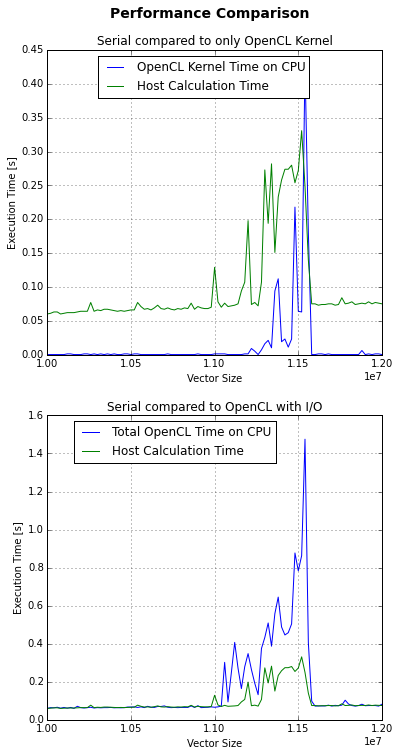

time: 667 ms


In [6]:
OCL_time = []
OCL_kernel_time = []
Serial_time = []
vec_size = []

for key in sorted(time_dict):
    Serial_time.append(time_dict[key][3])
    OCL_time.append(time_dict[key][4])
    OCL_kernel_time.append(time_dict[key][6])
    vec_size.append(key)
    if (VERBOSE >=2): 
        print("\nVector size:", key)
        print("Vector generation time:", time_dict[key][2], "s")
        print("Vector multiply time:", time_dict[key][3], "s")
        print("Total OpenCL VA time:", time_dict[key][4], "s")
        print("Transfer to device time: ", time_dict[key][5], "s")
        print("OpenCL VA kernel time: ", time_dict[key][6], "s")
        print("Transfer back to host time: ", time_dict[key][7], "s")

fig = plt.figure(figsize=(6,12))
fig.suptitle('Performance Comparison', fontsize = 14, fontweight = 'bold', y = 0.95)

plt.subplot(211)
plt.plot(vec_size, OCL_kernel_time, label='OpenCL Kernel Time on '+MY_DEVICE)
plt.plot(vec_size, Serial_time, label='Host Calculation Time')
plt.xlabel('Vector Size')
plt.ylabel("Execution Time [s]")
plt.title('Serial compared to only OpenCL Kernel')
plt.legend( bbox_to_anchor=(0.8, 1),ncol=1)
plt.grid(True)

plt.subplot(212)
plt.plot(vec_size, OCL_time, label='Total OpenCL Time on '+MY_DEVICE)
plt.plot(vec_size, Serial_time, label='Host Calculation Time')
plt.xlabel('Vector Size')
plt.ylabel("Execution Time [s]")
plt.title('Serial compared to OpenCL with I/O')
plt.legend( bbox_to_anchor=(0.7, 1),ncol=1)
plt.grid(True)

plt.show()
